First, let's install some libraries that we will need

In [1]:
!pip install matplotlib numpy

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple


In [2]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

# RANSAC

In this practical session we will implement RANSAC method for fitting a line to a noise dataset with outliers.

First, let's generate the noisy data with outliers.

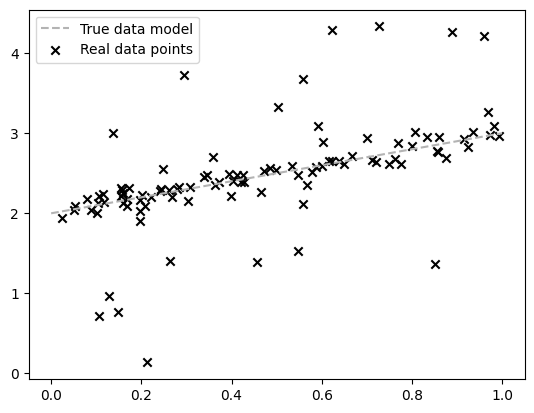

In [3]:
# Define true data model and generate data with regular noise
pts_n = 100
x = rng.uniform(size=pts_n)
a, b = 1, 2
true_y = a * x + b

noise_std = .1
noise = rng.standard_normal(pts_n) * noise_std
y = true_y + noise

# Add outliers
out_ratio = .3
out_n = round(pts_n * out_ratio)
out_ids = rng.choice(pts_n, out_n, replace=False)
out_scale = 10
y[out_ids] = true_y[out_ids] + (y[out_ids] - true_y[out_ids]) * out_scale

# Visualize
plt.plot([0, 1], [b, a + b], c=(.7, .7, .7), linestyle='dashed', label='True data model')
plt.scatter(x, y, c='black', marker='x', label='Real data points')
plt.legend()

Now, implement the `RansacLineFitter` class to fit this data using RANSAC.
Assume the standard deviation of the regular data noise `noise_std` to be known and use it for inlier detection.

The method `fit` implements a RANSAC-based algorithm on a high level.
**Your task** is to implement the rest of the methods.
Look for the code blocks labeled with `'Your code'`, both in the program code and the docstrings.
See how the `RansacLineFitter` is supposed to be used for fitting the data further as an example.

In [7]:
class RansacLineFitter:
    r"""Fits a linear model using RANSAC-based algorithm.

    Parameters
    ----------
    noise_std : float
        Assumed standard deviation of the regular data noise.
    """
    def __init__(self, noise_std):
        self.noise_std = noise_std
    
    def fit(self, data, max_iters_n=10, print_scores=False):
        r"""Fits a linear model to the {data}.
        
        Parameters
        ----------
        data : np.ndarray
            of shape [pts_n, 2], data points [(x1, y1), (x2, y2), ...].
        max_iters : int
            Maximum number of iterations.
        print_scores : bool
            If True, prints the progression of scores and best scores.
        
        Returns
        -------
        model : tuple of floats
            (a, b) parameters of the found model.
        """
        self.max_iters_n = max_iters_n
        
        did_converge = False
        iters_n = 0
        best_model, best_score = None, 0
        while not did_converge:
            sample = self.sample_data(data)
            model = self.fit_to_subsample(sample)
            score = self.evaluate_model(model, data)
            if score > best_score:
                best_score, best_model = score, model
            if print_scores:
                print(str(iters_n).rjust(6) + ': Current score ' + str(score).rjust(6) + ', Best score ' + str(best_score).rjust(6))
            iters_n +=1
            did_converge = self.check_convergence(iters_n)
        return best_model

    def sample_data(self, data):
        r"""Samples two data points suitable for fitting a linear model.
        Parameters
        ----------
        data : np.ndarray
            of shape [pts_n, 2], data points [(x1, y1), (x2, y2), ...].
        
        Returns
        -------
        sample : np.ndarray
            of shape [2, 2], two randomly selected data points.
        """
        # You may need https://numpy.org/doc/2.2/reference/random/generated/numpy.random.Generator.choice.html
        rng = np.random.default_rng()
        indices = rng.choice(len(data), size=2, replace=False)
        sample = data[indices]
        return sample

    def fit_to_subsample(self, sample):
        r"""Fits a line to a pair of points.
        
        Parameters
        ----------
        sample : np.ndarray
            of shape [2, 2], two data points [(x1, y1), (x2, y2)].
        
        Returns
        -------
        model : tuple of floats
            (a, b) parameters of the line model y = ax + b.
        """
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        # Handle vertical line case (same x coordinates)
        if x1 == x2:
            # For vertical lines, we can't use y = ax + b form
            # We'll return a very large slope as approximation
            a = 1e10 if y2 > y1 else -1e10
            b = y1 - a * x1
        else:
            # Calculate slope and intercept: y = ax + b
            a = (y2 - y1) / (x2 - x1)
            b = y1 - a * x1
        
        return (a, b)
        
    def evaluate_model(self, model, data):
        r"""Computes the number of inliers in the data described by the model.
    
        Parameters
        ----------
        model : tuple of floats
            (a, b) data model y = ax + b.
        data : np.ndarray
            of shape [pts_n, 2], data points [(x1, y1), (x2, y2), ...].
    
        Returns
        -------
        inliers_n : int
            Number of inliers.
        """
        inlier_ids = self.get_inlier_ids(model, data)        
        inliers_n = len(inlier_ids)
        return inliers_n

    def get_inlier_ids(self, model, data):
        r"""Identify ids of inliers in the data described by the model.

        We assume that the regular data noise is normal with a known standard deviation and define the max error for inliers as three standard deviations.

        Parameters
        ----------
        model : tuple of floats
            (a, b) data model y = ax + b.
        data : np.ndarray
            of shape [pts_n, 2], data points [(x1, y1), (x2, y2), ...].
    
        Returns
        -------
        ids : np.ndarray
            of shape [inliers_n], ids of inliers.
        """
        a, b = model
        x_coords = data[:, 0]
        y_coords = data[:, 1]
        
        # Calculate predicted y values using the model
        y_predicted = a * x_coords + b
        
        # Calculate residuals (errors)
        residuals = np.abs(y_coords - y_predicted)
        
        # Define inlier threshold as 3 * noise_std
        threshold = 3 * self.noise_std
        
        # Find indices where residuals are below threshold
        inlier_ids = np.where(residuals <= threshold)[0]
        
        return inlier_ids

    def check_convergence(self, iters_n):
        r"""Check for convergence.

        We simply check if the max number of iterations was performed.
        An alternative way would be to check for a good enough ratio of inliers, e.g inliers_n >= data_size * .8.
    
        Parameters
        ----------
        iters_n : int
            Current number of iterations performed.
    
        Returns
        -------
        did_converge : bool
        """
        return iters_n >= self.max_iters_n

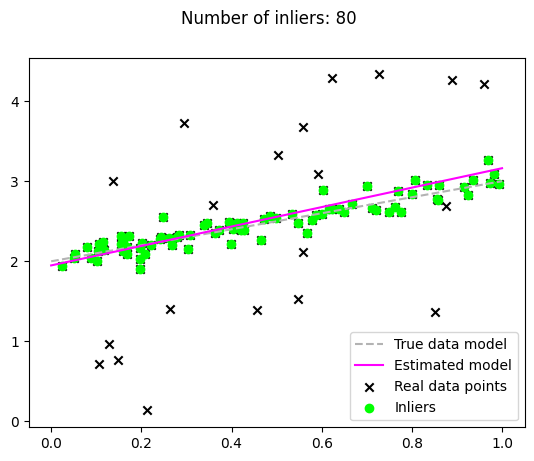

In [8]:
# Find the data model using RANSAC
ransac = RansacLineFitter(noise_std)
data = np.stack([x, y], -1)
(a_est, b_est) = model = ransac.fit(data)

# Visualize
inlier_ids = ransac.get_inlier_ids(model, data)

plt.plot([0, 1], [b, a + b], c=(.7, .7, .7), linestyle='dashed', label='True data model')
plt.plot([0, 1], [b_est, a_est + b_est], c='magenta', label='Estimated model')
plt.scatter(x, y, c='black', marker='x', label='Real data points')
plt.scatter(x[inlier_ids], y[inlier_ids], c='lime', marker='o', label='Inliers')
plt.suptitle(f'Number of inliers: {len(inlier_ids)}')
plt.legend()